# Классификация временных рядов с помощью модели Transformer

Максимальное чиисло баллов - 50, проходной балл - 20.

## Загрузка данных (15 баллов)

In [ ]:
import numpy as np


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Зафиксируйте число уникальных меток классов в переменной n_classes (5 баллов)

In [ ]:
n_classes = len(np.unique(y_test))

Рандомно перемешайте выборки (5 баллов)


In [ ]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=1)
x_test, y_test = shuffle(x_test, y_test, random_state=1)

Преобразуйте метки классов в 0 и 1 (5 баллов)

In [ ]:
y_train[y_train == -1] = 0
y_train[y_train == 1] = 1

y_test[y_test == -1] = 0
y_test[y_test == 1] = 1

## Модель (15 баллов)

Наша модель обрабатывает тензор формы `(размер батча, длина последовательности, признаки)`,
где «длина последовательности» — это количество временных шагов, а «признаки» - это каждый входной временной ряд.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

Дополните энкодер (15 баллов)

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim = head_size, num_heads = num_heads , dropout = 0
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Напишите Feed Forward блок 
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dense(head_size)(x)
    return x + res


In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    #уменьшим выходной тензор части «TransformerEncoder» до вектора признаков для каждой точки данных в текущем батчее
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Обучите и оцените качетсво модели (10 баллов)

In [ ]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.2,
    dropout=0.25,
)

#Скомпелируйте модель, используя sparse_categorical_crossentropy функцию потерь и sparse_categorical_accuracy метрику
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

model.summary()

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64
)

model.evaluate(x_test, y_test, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization_5 (LayerNo  (None, 500, 1)      2           ['input_5[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_5 (MultiH  (None, 500, 1)      7169        ['layer_normalization_5[0][0]',  
 eadAttention)                                                    'layer_normalization_5[0][0]']  
                                                                                            

[0.46555250883102417, 0.7886363863945007]

# Сделайте выводы по обучению и валидации модеели (10 баллов)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
matplotlib.rcParams['figure.dpi'] = 150
# Plotting results
def plot1(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


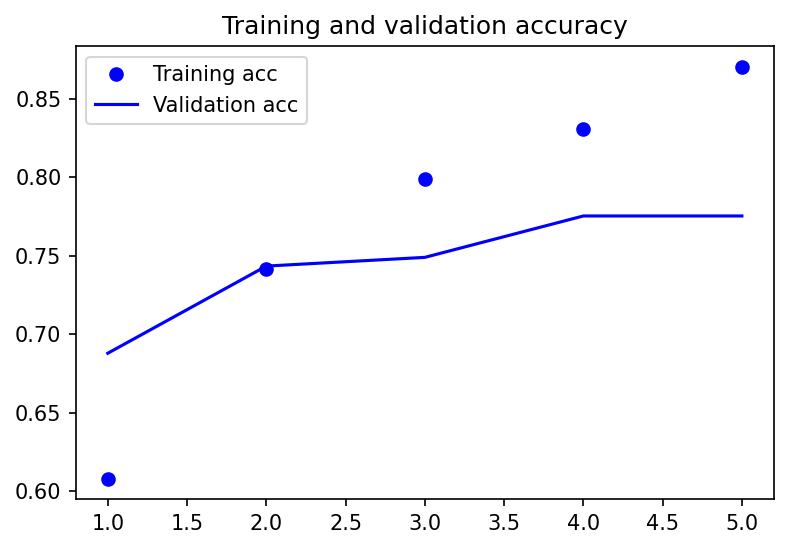

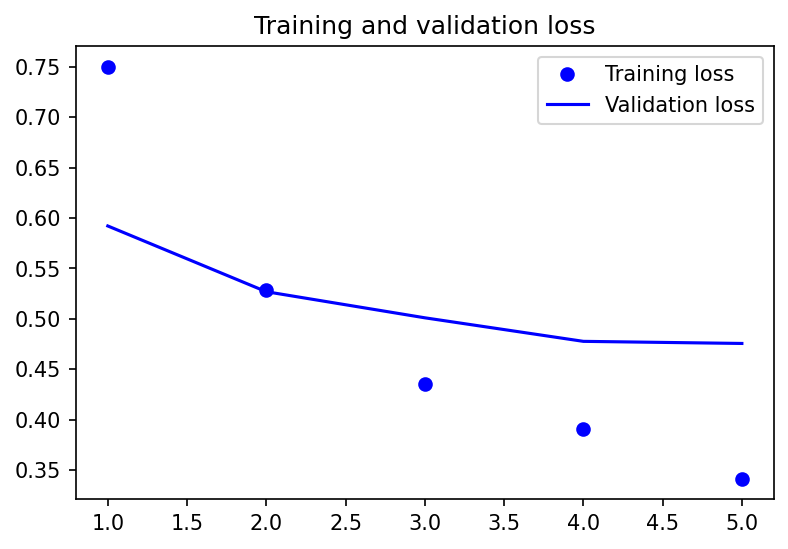

In [ ]:
plot1(history)